# Прогноз оттока. Кластеризация клиентов фитнес-центра
## Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
- Выделить целевые группы клиентов;
- Предложить меры по снижению оттока;
- Определить другие особенности взаимодействия с клиентами.

## Загрузка данных

In [1]:
# импорт необходимых библиотек
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette('Blues', as_cmap=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
# чтение файла
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# приведение название колонок к нижнему ругистру
gym_churn.columns = gym_churn.columns.str.lower()

# изучение общих сведений о данных
gym_churn.info()

# проверка на наличие явных (полных) дубликатов
gym_churn.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

0

Файл прочитался корректно.

Представленные на анализ данные содержат 12 признаков и информацию об оттоке в текущем месяце. Всего 4000 наблюдения. Пропущенные значения, явные (полные) дубликаты - отсутвуют. Данные представлены дикретными и непрерывными величинами.

**Описание данных:**

Данные клиента за предыдущий до проверки факта оттока месяц:

- gender — пол;
- near_location — проживание или работа в районе, где находится фитнес-центр;
- partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- phone — наличие контактного телефона;
- age — возраст;
- lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
- group_visits — факт посещения групповых занятий;
- avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
- avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
- avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- churn — факт оттока в текущем месяце.

##  Исследовательский анализ данных (EDA)

In [4]:
# статистики признаков и целевой переменной
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Итак, 4000 наблюдения по 12 признакам и целевой переменной пропусков не имеют.

Признаки пола, близости к фитнес-центру, парнерскому статусу, наличия контакта клиента, посещения гупповых тренировок и отток клиента представлены бинарно.

Соответственно, если медиана указнных призанков находиться в единице, то половина клиентов фитнес-центра имеют либо мужской пол (для признака гендерной принадлежности), либо статус "Да" для прочих указанных признаков.

Значение среднего свидетельсвует о смещении (скосе) признака вправо или влево относительно значения 0,5. Так, среднее значение гендера равно 0,51 - большиство клиентов мужского пола, 0,84 для призанака о близкой к фитнес-центру локации свидетельствует о таковой для большинства клиентов. Далее. 48% процентов клиентов работат в партнерских компаниях, 31% приняли участие в промо-акции, подавляющее большинство (90%) поделилось контрактной информацией, 41% клиентов посещают груповые тренировки. И, отток на текущей месяц по имеющимся анлюдениям составляет 26% - четвертть пользоватлей покину сервис. Таким образом, целевая переменная распределена диспропорционально.

Стандратное отклонение при бинарном распределении имеет противополжное от среднего значение.

Сведения о длительности абонемента, возрасте, прочих расходов, срока до окончания абонемента, лайфтамы, средние частоты посещения зала в неделю клиента представлены дискретными и непрерывными значениями. Рассмотрим статистики признаков, совместно с визуализацией распределениий.

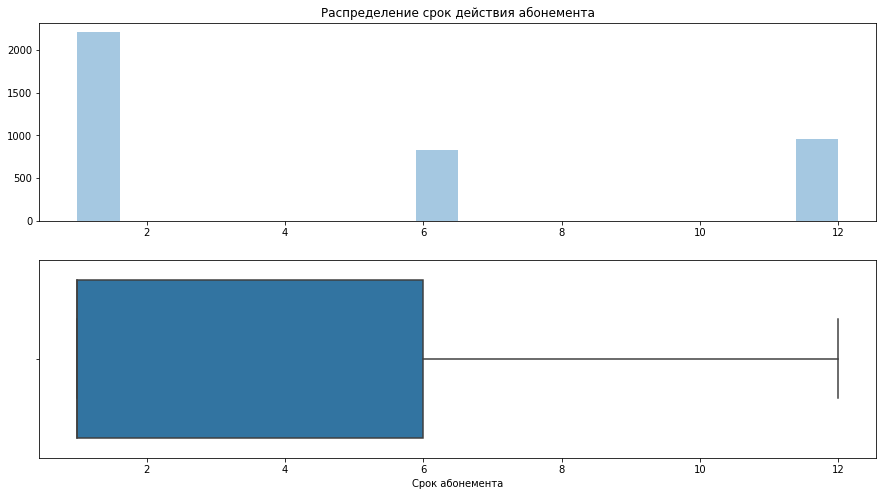

In [5]:
# функция для построения графика распределения признака
# принмает в качестве агрумента признак, название признака, единицу измерения признака
# возвращает гистограмму частот и диаграмму размаха
def get_distribution_plot(feature, title, label):
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.title(title)
    sns.distplot(feature, kde=False)
    plt.xlabel('')
    plt.subplot(2, 1, 2)
    sns.boxplot(feature)
    plt.xlabel(label)
    plt.show()
    

# визуализация распределения срока действия абонемента
get_distribution_plot(gym_churn['contract_period'], 
                      title='Распределение срок действия абонемента', 
                      label='Срок абонемента')

Распределение длительности дейтсивя абонемента имеет три моды. Большинство пользователей приобретают абонемент на срок до двух месяцев. Однако, среднее значение в пять месяцев и стандартное отклонении в в 4,54 месяца свидетельствует о достаточно широком распределении признака. Медиана признака равна единице - половина пользоватлей покупает абонемент на месяц, при этом 75% пользоватлей приобретают абонемент на полгода. Такое смещение длительности контракта объясняется наличием клиентов с годовым абонементом, превышающем число клиентов с пологодовым абонементом. Пользователей с абонементом превышащей годовой горизонт - нет, очевидно такое предложение на рынке отсутсвует.

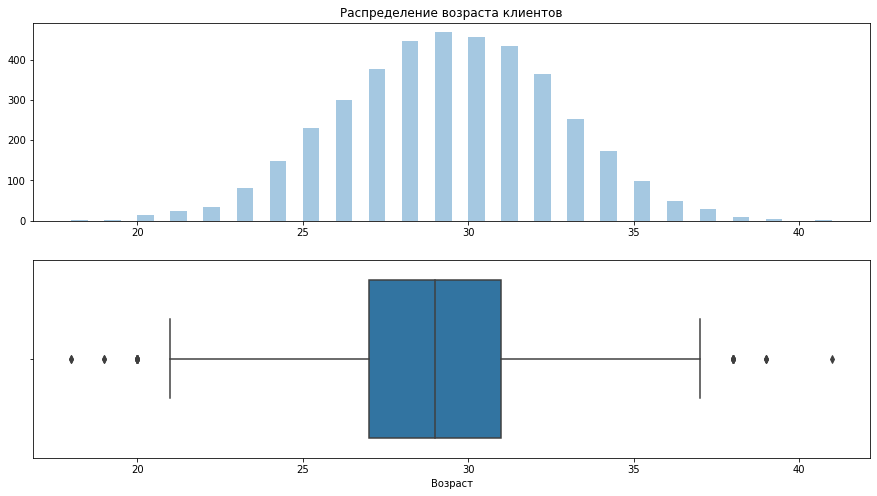

In [6]:
# визуализация распределения возраста клиентов
get_distribution_plot(gym_churn['age'],
                     title='Распределение возраста клиентов',
                     label='Возраст')

Распределение возраста клиентов фитнес-центра имеет классический нормальный характер со среднем значением в 29 лет равным медиане. Стандартное отклонение 3,25 лет. Аномальными представлется возможным признать возраст клиентов страше 36 лет и моложе 21 года - таких клиентов шесть.

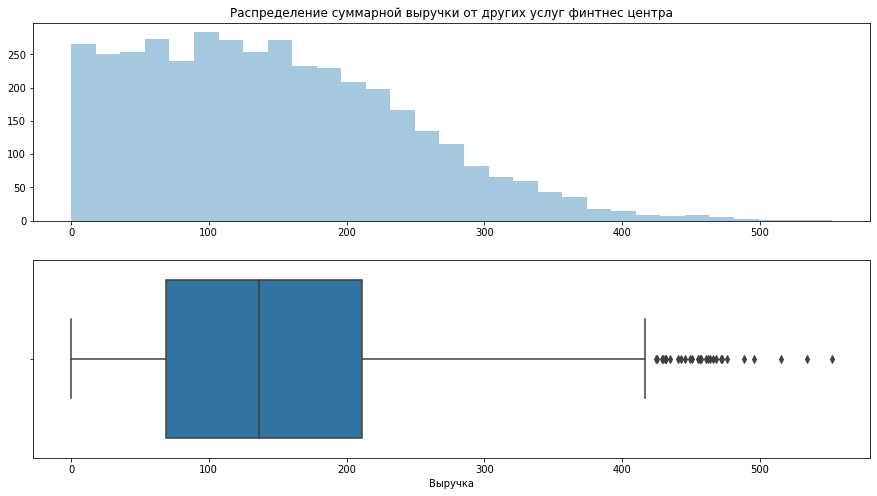

In [7]:
# визуализация распределения суммарной выручки от других услуг финтнес центра
get_distribution_plot(gym_churn['avg_additional_charges_total'],
                     title='Распределение суммарной выручки от других услуг финтнес центра',
                     label='Выручка')

Выручка, как и любой прочий результат деятельности целовека, всего имеет скошенное вправо распределение: большинство пользоватлей несут расходы близкие к нулю, а редкие аномалии тратят значительные средства.

Так, среднее значение выручки в 146, при медиане в 136 говорит о наличии "жирного" хвоста, который "перетягиевает" на себя статистику - среднее значение. 25% клиентов тратят на прочие услуги 68, 75% - 210. Максимльное значение выручки от прочих услуг фитнес-центра равно 552. Анамально высокими значениями выручки представлется возмодным признать значения больше 318. Стандатное отклонение в 96 - свидетельствет о достаточно широком распределении признака.

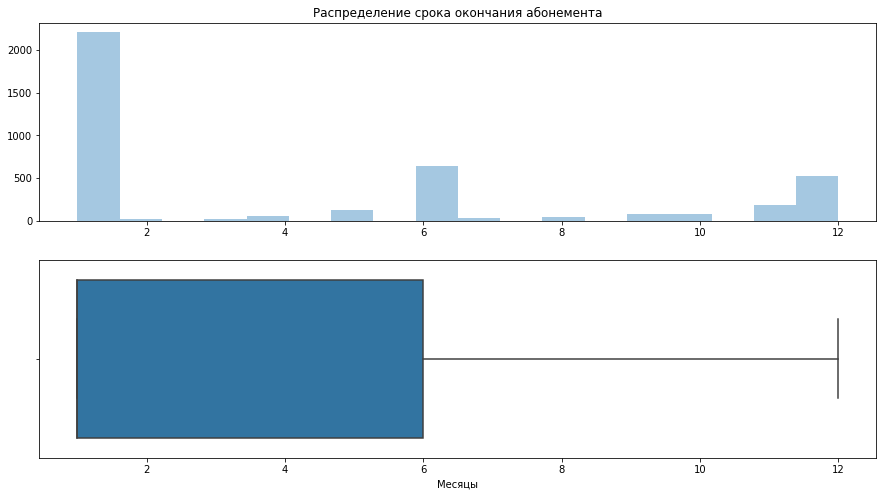

In [8]:
# визуализация распределения срока окончания абонемента
get_distribution_plot(gym_churn['month_to_end_contract'],
                     title='Распределение срока окончания абонемента',
                     label='Месяцы')

Итак, в виду наличия трех мод у распредления длительности абонемента, распределение срока окончания абонемента также имеет три ярко выраженные группы: месяц до окончания абонемента - это те пользоватлеи, которые приобретают контракт ежемесячно; полгода и год - соответсвенно пользователи с пологодовыми и годовыми абонементами.

По этой же причины статистики распределения количества месяцов до кончания абонемента схожи со статистиками длительности абонемента: медиана в единце, среднее значение 4 месяца при стандартном отклонении в 4 месяца.

У ряда пользователей срок окончания абонемента истекает соответсвенно через 4 и 5 месяцев - это могут быть пользоватлеи, как с годовыми, так и с пологодовыми картами, у некоторых срок дествия истекает через 8-10 месяцев - это клиенты с годовой картой.

Таким образом, на стадии исследовательского анализа, можно сделать вывод, что предсказывать отток клиентов модель будет у 50% пользователей с сроком дейтсвия карты до месяца. При этом, из предоставленных данных, достоверно известно, что 26% пользоватлей не продлят абонемент. Таким образом, маркетиноговые усилия стоит сосредоточить на порядка 15% отказников.  

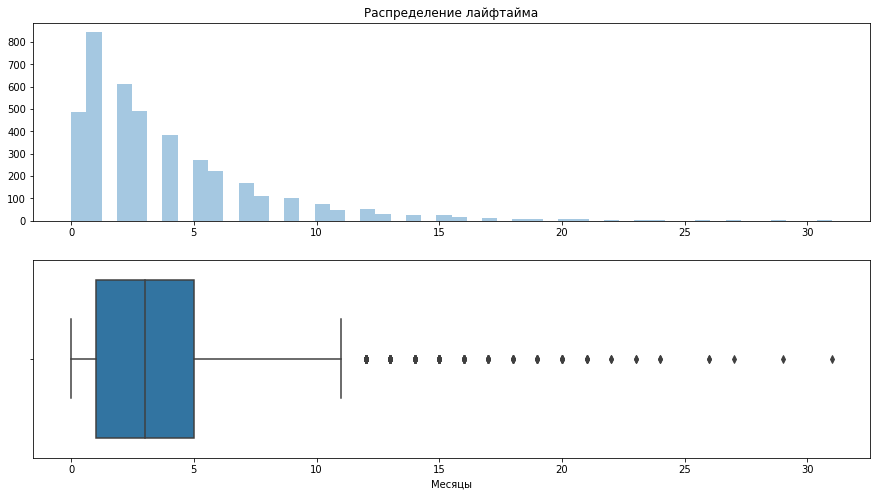

In [9]:
# визуализация распределения лайфтайма
get_distribution_plot(gym_churn['lifetime'],
                     title='Распределение лайфтайма',
                     label='Месяцы')

Итак, в среднем клиенты посещают зал на протяжении четырех месяцев, при этом половина клиентов пользуется центром три месяца. Шикорое распределение лайфтайма со стандартными отклонением в 4 месяца говорит, как о наличии целевой аудитории у зала, так и о наличии у зала "подснежников" - сезоных посетителей тренировок.

Аномально длительным лайфтайм представляется воможным признать значения превышающие 11 месяцев, то такие уникумов в представленной выборке из 4000 наблюдений всего 17.

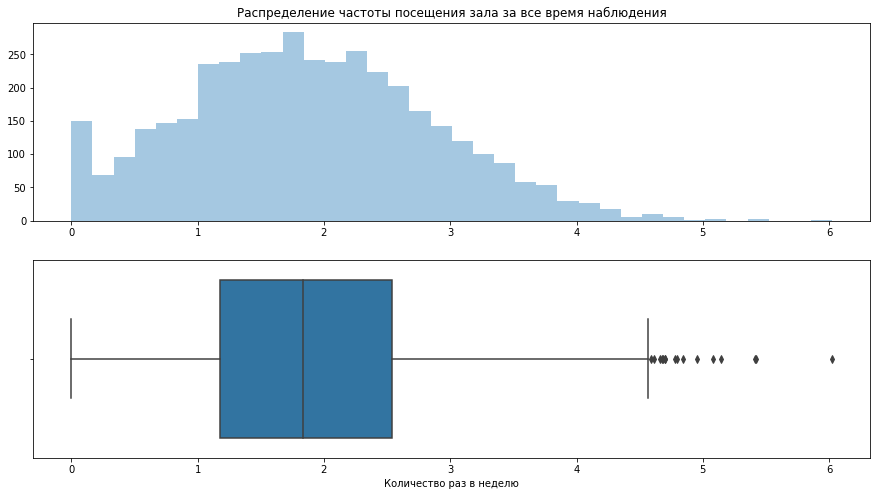

In [10]:
# визуализация распределения частоты посещения зала за все время наблюдения
get_distribution_plot(gym_churn['avg_class_frequency_total'],
                     title='Распределение частоты посещения зала за все время наблюдения',
                     label='Количество раз в неделю')

Итак, типичный клиент фитнес-центра посещает зал в среднем два раза при медиане также в два посещения и стандартном отклоение в одно посещение в неделю.

При этом порядка 150 пользователей так ни разу и не посетили зал, не смотря на наличие абонемента, а также в представленной выборке имеються настоящие атлеты посещащие зал более 4,75 раз в неделю в среднем. Их 13.

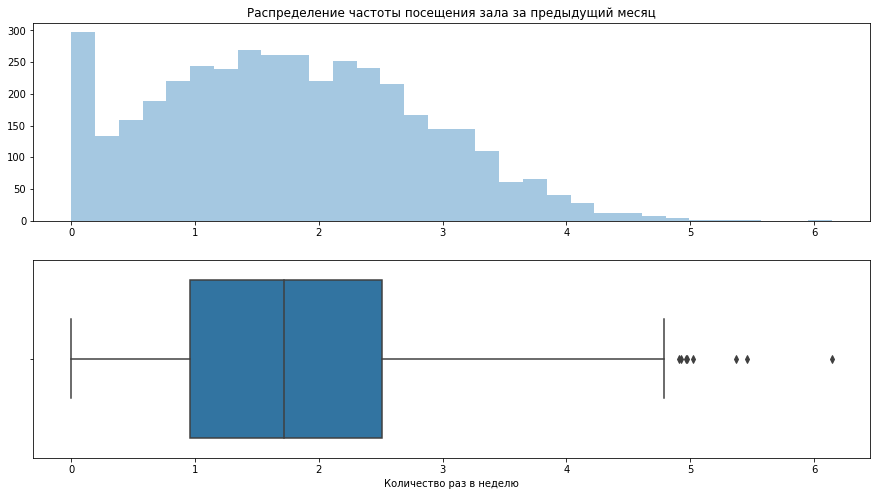

In [11]:
# визуализация распределения частоты посещения зала за предыдущий месяц
get_distribution_plot(gym_churn['avg_class_frequency_current_month'],
                     title='Распределение частоты посещения зала за предыдущий месяц',
                     label='Количество раз в неделю')

Распределение частоты посещения зала за прошлый месяц схоже с распределением частоты посещения зала за все время наблюдения. Так среднее чуть меньше 1,7 против 1,8 за все время, медиана 1,7 ппротив 1,8 за все время, и незначитльный рост в 1 посещение против 0,9 за все время. Таким образом, распределение смещается к нулю и становиться шире.

Кроме того, количество пользоватлей прекращающих посещать зал приближается в 300 против 150 за все время, а чило атлетов сократилось до 7. Очевидно, в представленной выборке, наблюдается замедление интенсивности пользованием сервиса за последний месяц. Видимо, такое смещение к нулю распределения обуславливает поведение тех 26% пользоватлей покинувших фитнес-центр.

Рассмотрим, как признаки взаимодействует между собой и целевой переменной.

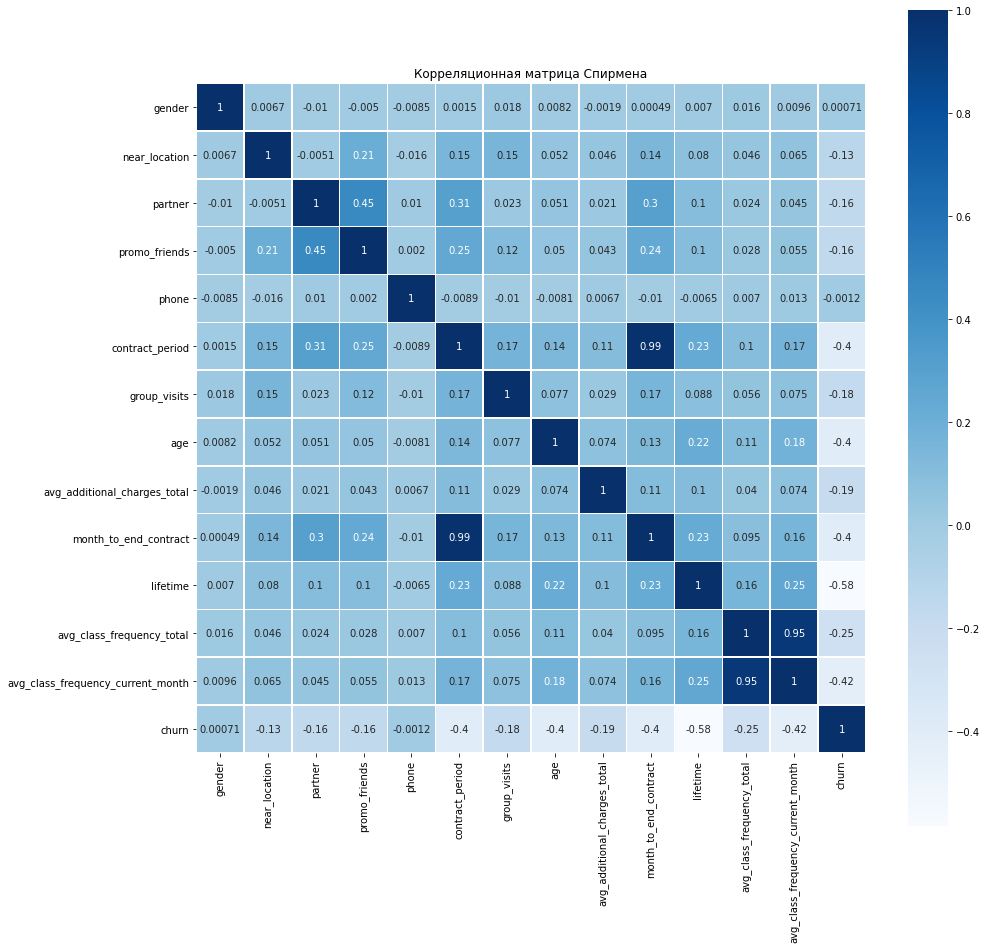

In [12]:
# корреляционная ранговая матрица
plt.figure(figsize=(15, 15))
sns.heatmap(gym_churn.corr(method='spearman'), annot=True, square=True, linewidths=.5, cmap='Blues')
plt.title('Корреляционная матрица Спирмена')
plt.show()

В ходе изучения распределения признаком целевой переменной отмечено наличие выбросов - явно выбивающихся значений из выборки, в связи с чем применем ранговую модель корреляции для оценки наличия возможной линейной взаимосвязи между данными.

Так, очевидно, между собой сильно коррелируют признаки срока действия абонемента и количество месяцев до окончания абонемента, а также среднее количество посещений в неделю за весь период наблюдений и за последний месяц. Прочих сильных связей не выявлено. 

При этом ожидаемая связь между расходами клиента на прочие услуги фитнес центра и срок абонемента, лайфтаймом и частотой посещений в неделю не выявлено, что странно: клиенты, которые живут в сервисе долго и часто посещают зал, обычно приносят больше дополнительной выручки.

Дополнительно отменим, что целевая переменная больше всего отрицательно коррелирует с частотой посещения зала в неделю в последнем месяца и лайфтаймом. Логично. Чем дольше клиент у нас в сервисе и чем комфортнее ему у нас пребывать, тем меньше шансов, что он уйдет. Однако, возможны варианты, что клиент решил покунуить зал и интенсивно "дохаживает" действующий абонемент.

Возраст и срок абонемента также явлются решающими факторами: чем моложе пользователь, тем больше вероятность, что он останется с нами и чем короче период контракта клиента, тем вероятнее всего он покинет зал. Что вполне логично, возможно, зал не возращает деньги при разрыве договора или возможно система взаимодействия с пользователями считает пользователя "живым", пока у него активный контракт. 

Половая принадлженость и факт оставления контакта клиента не влияют на отток.

Рассмотрим средние значения признаков клиентов отдельно по группам: те, кто остался и те, кто покунул зал.

In [13]:
# рассчет средних значений признака по группам
gym_churn.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Таким образом, как было отмечено ранее, пол и оставление контактов не влияет на отток: по 51% мужчин в обоих группах и по 90% оставивших контакт в обоих группах, а проживание и работа вблизи зала, а также парнерский характер взаимотноений, наличии промо влияют и посещение групповых занятий влияют: так 87% против 77% остались в сервисе, если работают или живут рядом с залом; 53% против 35% остались, если работодатель парнер фитнес-центра, 35% против 18% не оттекли, если воспользовались промо-акцией, 46% против 27% процентов остались в зале, если посещают групповые занятия.

Средняя длительность абонемента у оставшихся в сервисе полгода против 1,7 месяца у группа оттока, средний возраст у оставшихся клиентов 30 лет, у покинувших 27 лет. Ушедшие польователи тратят в среднем 115 против 158 у сохранивших абонемент; пять месяцев против одного лайфтайм оставшихся пользоватлей и средняя частота посещения два раза в неделю против 1,5 и одного соответсвенно у оттока.

## Модель прогнозирования оттока клиентов

LogisticRegression(C=0.5, solver='liblinear')

    accuracy_score: 0.93,
    precision_score:0.89,
    recall_score: 0.839622641509434,
    f1_score: 0.8640776699029127,
    roc_auc_score: 0.9777628032345013
              


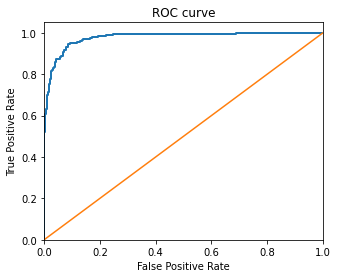

RandomForestClassifier(max_depth=10, n_estimators=50)

    accuracy_score: 0.9225,
    precision_score:0.8712871287128713,
    recall_score: 0.8301886792452831,
    f1_score: 0.8502415458937197,
    roc_auc_score: 0.9712167886022334
              


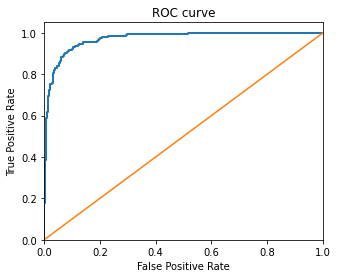

In [14]:
# разделение данных на матрицу признаков и целевую переменную
X = gym_churn.drop(['churn'], axis=1)
y = gym_churn['churn']

# создание объекта класса scaler
# обучение и стандартизатора и преобразование данных
scaler = StandardScaler() 
X = scaler.fit_transform(X)

# разделение данных на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)

# формирование списка используемых алгорином обучения
models = [LogisticRegression(solver='liblinear',
                            C=.5),
         RandomForestClassifier(n_estimators=50,
                               max_depth=10)]

# создаем функцию для обучения, прогноза и получения метрик моделей
# функция принмает на вход модел с параметрами, обучающие и валидационные выборки
# возвращает метрики прогнозов моделей
def make_prediction(mоdel, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_probabilities = model.predict_proba(X_test)[:,1]
    print(f'''
    accuracy_score: {accuracy_score(y_test, y_predict)},
    precision_score:{precision_score(y_test, y_predict)},
    recall_score: {recall_score(y_test, y_predict)},
    f1_score: {f1_score(y_test, y_predict)},
    roc_auc_score: {roc_auc_score(y_test, y_probabilities)}
              ''') 

# инициализация модели, обучение, прогноз, расчет метрик
for model in models:
    print(model)
    make_prediction(model, X_train, y_train, X_test, y_test)

# визуализация  receiver operating characteristic curve
    plt.figure(figsize=(5, 4))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, 
                                                                    model.predict_proba(X_test)[:,1], 
                                                                    pos_label=1)
    plt.plot(false_positive_rate, true_positive_rate, lw=2, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

По метрике доли верных ответов несколько лидирует логистическая регрессия, 92,25% против 91,37% у алгоритма случайного леса. Однако, следует отметить, что метрика accuracy достоверно оценивает модели только при балансе классов, что в представленной выборке отсутствует, соотношение оттока к оставшимся в сервисе клиентов - 26/74.

Метрики precision и recall рассчитываются без привязки к классам, при этом метрика точность 85,41% у логрегрессии против 83,41% у классификатора случайного леса, показывает долю правильных ответов среди целевого класса, в данном случае в оттоке. Однако, для целей удержания клиента, важна метрика полнота - сколько реальных оттоков смог обнаружить алгоритм, при этом  даже если алгоритм будет срабатывать "ложно", лишним внимание к клиенту со стороны персонала фитнес-центра не будет. Точность логистичекой регресии выше классификатора случайного леса: 82,82% против 81,31%.

По метрики баланса между точностью и полнотой - F1, лидирующую позиция также заняла логистическая регрессия, 86,40% против 83,74% у случайного леса.

Метрика вероятности отнесения объекта к классу ROC-AUC оценивает модель в случае разбалансировки классов, как раз такой вариант событий представлен в выборке. Показатель логистической регрессии на 0,77 п.п. лучше показателя случайного леса, 97,77% против 97,00%. 

Таким образом, логистическая регрессия обходит алгоритм случайного леса по всем выбраным оценкам. Ключевым скором для прогнозирования оттока клиентов является recall.

## Кластеризация пользователей

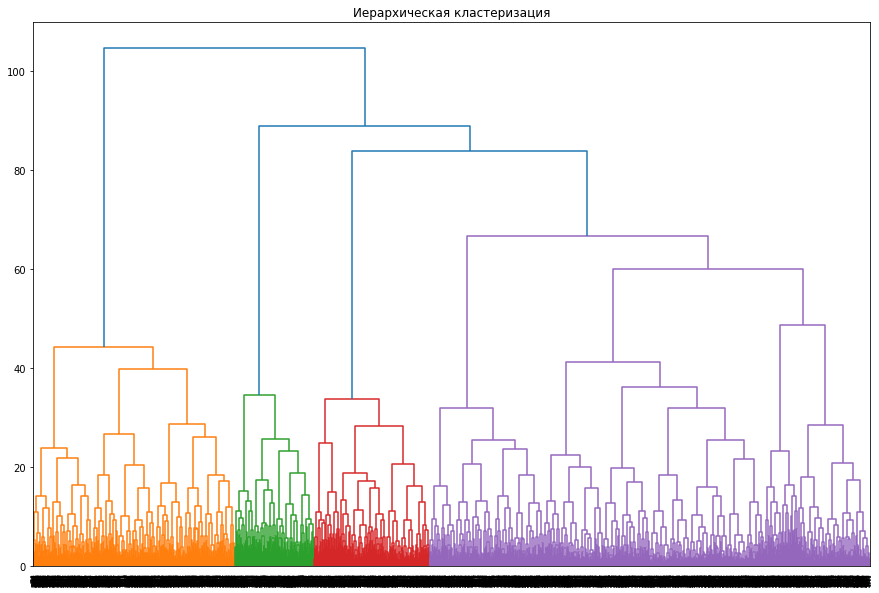

In [15]:
# построение матрицы расстояний
linked = linkage(X, method='ward')

# визуализация связей дендрограммой
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Таким образом, модель иерархической кластеризации предлагает выделить четыре кластера.

Согласно заданию выделим пять кластеров.

In [16]:
# кластеризация пользоватлей, число кластеров - пять
# инициализация алгоритма
km = KMeans(n_clusters=5, random_state=0)

# обучение модели и прогноз
labels = km.fit_predict(X)

# расчет средних значений признаков по кластерам клиентов
gym_churn['cluster'] = labels
gym_churn.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


In [20]:
# оценка важности признаков при классификации методом случайного леса
features = gym_churn.columns
feature_importances = (
    RandomForestClassifier(n_estimators=50, max_depth=10)
    .fit(X_train, y_train)
    .feature_importances_
)

pd.DataFrame(list(zip(features, feature_importances)), columns=['features','feature_importances'])

,features,feature_importances
0,gender,0.008458
1,near_location,0.006688
2,partner,0.010189
3,promo_friends,0.008678
4,phone,0.005328
5,contract_period,0.064025
6,group_visits,0.014931
7,age,0.120844
8,avg_additional_charges_total,0.075285
9,month_to_end_contract,0.104349


Итак, клиенты разделены на пять групп. 

Основой для классификации на группы выступили следующие признаки: 

- лайфтайм; 
- средняя посещаемость зала в неделю за текущий месяц; 
- средняя посещаемость зала за все время наблюдения; 
- возраст; 
- расходы клиента на сопутсвующие услуги;
- количество месяцев до окончания контракта(длительность контраткта).

Рассмотрим типовые особенности каждого кластера:

1. Пол. Доля мужчин и женщин в каждой группе примерно равная, выделяется пятый кластер с преобладащей долей мужчин в 55%. Пол не явлется основанием разделения на группы.
2. Проживание и работа вблизи зала. Все группы за исключение тертьей проживают или работают вблизи фитнес центра, в группе два 86% таковых, в прочих группах значения близке к единице. Близкое расположение явлется основанием для выдления в отдельную группу третьего кластера.
3. Работодатель - парнер клуба. Первый кластер лидерует по данному показателю - 78% клиентов трудоустроены у парнера клуба. По 35% клиентов-парнеров у четвертого и пятого, примерно равная доля у второго и третьего - 47% и 46% соответсвенно. Партерские отношения являются основанием для выделения преобладающего по данному признаку первого кластера.
4. Промо-акция. В большей степенью промо-акцией воспользовалиьс клиенты группы 1 - 57%, в меньшей - клиенты группы 3 - 8%. В равных долях акционые пользоватлеи присутсвуют в четвертом и пятом кластере - 23-24%, 30% во втром сегменте. Промо стало основанием деления на кластеры для алгоритма: веса пользоватлей по группам различаются значительно.
5. Контакт. Все группы, за исключением второй, поделились контактыми данными. Контакты пользователя стали основанием для выделения одного (второго) сегмета клиентов.
6. Срок абонемента. Представили первой группы приобретают годовой абонемент, представители четвертой группы приобретают абонемент помесячно, клиенты из второй, третьей и пятой группы преобретают квартальные абонементы. Длительность абонемента позволило алгоритму разделить клиентов на три группы: первый кластер, четвертый кластер и клиенты второго, третьего и пятого кластеров.
7. Групповые тренировки. 54% клиента первого сегметна, 47% пятого сегмента и 42% второго сегмента посещают групповые тренировки. В меньше степени к групповым занятиям тяготеют представители третьего и четвертого сегментов - 21% и 34% посещают такие тренировки. Признак посещения групповых тренировок позволяет выделить три кластера пользователей.
8. Возраст клиентов. Средний возраст клиентов по кластерам совпадает со среднем возрастом всей, представленной на анализ выборки, - 28-30 лет. Возраст не явлется основанием разделения на группы.
9. Траты клиентов на сопутсвующие услуги. Примерно по 160 составляет выручка клуба от клиентов первого и пятого кластеров, 144 от второго кластера и 131-135 от клиентов третьего-четвертого сегментов. Алгоритм выявил три группы, опираясь на сопуствующие расходы пользоватлей.
10. Месяцев до окончания контракта. Аналогично признаку длительности абонемента, алгоритм разделил пользователь на три группы: 10 месяцев до истечения абонемента (первая группа), пять месяцев (вторая группа), по три месяца - третья и пятая группы и месяц для четвертой группы.
11. Лайфтайм. Три сегмента: 5 месяцеыв в среднем посещают зал представители первого и пятого сегмента, 4 месяца - второго сегмента и по 3 месяца третьего-четвертого сегмента.
12. Среднее количество тренировок в неделю за все время наблюдения/за текущий месяц. Схожее деление продемонстрировал алгоритм: три, две и одна тренировка в месяц у пятого, первого-второго и третьего-четвертого кластеров.

Оценим долю выбывших по кластерам и охаратеризуем группы по надежности и оттоку.

1. Клиенты третьего и четвертого кластеров склонны покидать клуб - 44% и 51% соответсвенно.

Это клиенты, которые в меньшей степени являются парнерскими организациями, воспользовались промо, с месячным абонементом, не любители групповых тренировок и не склонные к приобретению сопуствующих услуг клуба. Сервисом пользуются не более трех месяцев и склонны посещать зал раз в неделю.

2. Клиенты первого и пятого кластеров относятся к категории якорных пользоватлей - 2% и 6% покинули клуб.

Это клиенты парнерских сервисов, воспользовалиьс акцией при покупки абонемента, срок абонемета от квартала до года, завсегдатеи групповых занятий, не скупятся на услуги массажа и протеинвого шейка, с клубом знакомы более полугода, посещают зал три раза в неделю.

3. Нейтральные пользователи - второй сегмент 26% оттока. 

Занимают промедуточное положение. Являются точкоц приложения усилий продуктовых и маркетинговых спеиалистов с целью перехода в разряд надежных клиентов.

Таким образом, целесообразно выделить три кластера клиентов - надежные, нетральные, уходящие.

Далее дополнительно изучим распределние признаков клиентов по кластерам.

In [ ]:
# визуализация распределений признаков по кластерам
plt.figure(figsize=(20, 20))

# возраст клиентов по кластерам
plt.subplot(5, 5, 1)
sns.distplot(gym_churn[gym_churn['cluster'] == 0]['age'], kde=False)
plt.title('Первый кластер')
plt.xlabel('Возраст клиента')

plt.subplot(5, 5, 2)
sns.distplot(gym_churn[gym_churn['cluster'] == 1]['age'], kde=False)
plt.title('Второй кластер')
plt.xlabel('Возраст клиента')

plt.subplot(5, 5, 3)
sns.distplot(gym_churn[gym_churn['cluster'] == 2]['age'], kde=False)
plt.title('Третий кластер')
plt.xlabel('Возраст клиента')

plt.subplot(5, 5, 4)
sns.distplot(gym_churn[gym_churn['cluster'] == 3]['age'], kde=False)
plt.title('Четвертый кластер')
plt.xlabel('Возраст клиента')

plt.subplot(5, 5, 5)
sns.distplot(gym_churn[gym_churn['cluster'] == 4]['age'], kde=False)
plt.title('Пятый кластер')
plt.xlabel('Возраст клиента')

# траты на сопутсвующие услуги
plt.subplot(5, 5, 6)
sns.distplot(gym_churn[gym_churn['cluster'] == 0]['avg_additional_charges_total'], kde=False)
plt.xlabel('Выручка с клиента')

plt.subplot(5, 5, 7)
sns.distplot(gym_churn[gym_churn['cluster'] == 1]['avg_additional_charges_total'], kde=False)
plt.xlabel('Выручка с клиента')

plt.subplot(5, 5, 8)
sns.distplot(gym_churn[gym_churn['cluster'] == 2]['avg_additional_charges_total'], kde=False)
plt.xlabel('Выручка с клиента')

plt.subplot(5, 5, 9)
sns.distplot(gym_churn[gym_churn['cluster'] == 3]['avg_additional_charges_total'], kde=False)
plt.xlabel('Выручка с клиента')

plt.subplot(5, 5, 10)
sns.distplot(gym_churn[gym_churn['cluster'] == 4]['avg_additional_charges_total'], kde=False)
plt.xlabel('Выручка с клиента')

# срок действия абонемента
plt.subplot(5, 5, 11)
sns.distplot(gym_churn[gym_churn['cluster'] == 0]['contract_period'], kde=False)
plt.xlabel('Срок действия абонемента, месяцы')

plt.subplot(5, 5, 12)
sns.distplot(gym_churn[gym_churn['cluster'] == 1]['contract_period'], kde=False)
plt.xlabel('Срок действия абонемента, месяцы')

plt.subplot(5, 5, 13)
sns.distplot(gym_churn[gym_churn['cluster'] == 2]['contract_period'], kde=False)
plt.xlabel('Срок действия абонемента, месяцы')

plt.subplot(5, 5, 14)
sns.distplot(gym_churn[gym_churn['cluster'] == 3]['contract_period'], kde=False)
plt.xlabel('Срок действия абонемента, месяцы')

plt.subplot(5, 5, 15)
sns.distplot(gym_churn[gym_churn['cluster'] == 4]['contract_period'], kde=False)
plt.xlabel('Срок действия абонемента, месяцы')

# лайфтам клиента
plt.subplot(5, 5, 16)
sns.distplot(gym_churn[gym_churn['cluster'] == 0]['lifetime'], kde=False)
plt.xlabel('Лайфтайм, месяцы')

plt.subplot(5, 5, 17)
sns.distplot(gym_churn[gym_churn['cluster'] == 1]['lifetime'], kde=False)
plt.xlabel('Лайфтайм, месяцы')

plt.subplot(5, 5, 18)
sns.distplot(gym_churn[gym_churn['cluster'] == 2]['lifetime'], kde=False)
plt.xlabel('Лайфтайм, месяцы')

plt.subplot(5, 5, 19)
sns.distplot(gym_churn[gym_churn['cluster'] == 3]['lifetime'], kde=False)
plt.xlabel('Лайфтайм, месяцы')

plt.subplot(5, 5, 20)
sns.distplot(gym_churn[gym_churn['cluster'] == 4]['lifetime'], kde=False)
plt.xlabel('Лайфтайм, месяцы')

# регулярность посещения зала (за все время наблюдения)
plt.subplot(5, 5, 21)
sns.distplot(gym_churn[gym_churn['cluster'] == 0]['avg_class_frequency_total'], kde=False)
plt.xlabel('Количество посещений в неделю')

plt.subplot(5, 5, 22)
sns.distplot(gym_churn[gym_churn['cluster'] == 1]['avg_class_frequency_total'], kde=False)
plt.xlabel('Количество посещений в неделю')

plt.subplot(5, 5, 23)
sns.distplot(gym_churn[gym_churn['cluster'] == 2]['avg_class_frequency_total'], kde=False)
plt.xlabel('Количество посещений в неделю')

plt.subplot(5, 5, 24)
sns.distplot(gym_churn[gym_churn['cluster'] == 3]['avg_class_frequency_total'], kde=False)
plt.xlabel('Количество посещений в неделю')

plt.subplot(5, 5, 25)
sns.distplot(gym_churn[gym_churn['cluster'] == 4]['avg_class_frequency_total'], kde=False)
plt.xlabel('Количество посещений в неделю')

plt.suptitle('Распределение признаков клиентов по кластерам', fontsize=15)
plt.show()

Итак, надежными признаны клиенты первого и пятого кластеров. Клиенты этих групп имеют схожее возрастное распределение, однако, в первой группе отсутвует возрастная категория 27, 31, 34 года, а в пятом кластере не представлены клиенты возрастной категории 26, 29, 34. Клиенты первого сегмета уверенно тратят до 250, а клиенты пятого - до 350 на сопутсвующие услуги, при этом в пятом сегменте есть польователи приносящие выручку до 500. надежные клиенты - это клиенты первого сегмента с преобладающим годовым абонементом, пятого сегмента с квартальным. Надежные клиенты уверенно пользуются продуктом до полугода, а ряд пользоватлей до 30 месяцев. Надежные клиенты тяготеют посеящат зал не менее трех раз в неделю, при этом ряд атлетов занимается по 5-6 раз в неделю.

Оттоку подвержены пользователи третьего и четвертого кластеров. Возраст преобладает либо 31 год либо 27 лет (то есть эти тот возрастной период, который "выпал" из надежных кластеров). Дополнительная выручка с таких клиентов в большинстве своем не превышает 200, срок действия абонемента строго до квартала. Это клиенты, которые знакомы с залом до двух месяцев и посещают зал не более шести раз в месяц.

Нейтральные клиенты - второй кластер. Поля для работы продуктовых и маркетинговых отделов.

Исходя из полученных данных, дадим общие реккомендации по снижению оттока клиентов.

## Выводы

1. Клиенты фитнес-центра харатеризуються следующими признаками: 51% клиентов мужского пола, 84% клиентов относятся к близкой к фитнес-центру локации, 48% процентов клиентов работат в партнерских компаниях, 31% приняли участие в промо-акции, 90% поделилось контрактной информацией, 41% клиентов посещают груповые тренировки, отток на текущей месяц по имеющимся наблюдениям составляет 26%.

2. Результаты пользования сервисом по имеющимся данным следующие. Большинство пользователей приобретают абонемент на срок до двух месяцев. Однако, среднее значение в пять месяцев и стандартное отклонении в в 4,54 месяца свидетельствует о достаточно широком распределении признака. Медиана признака равна единице - половина пользоватлей покупает абонемент на месяц, при этом 75% пользоватлей приобретают абонемент на полгода. Такое смещение длительности контракта объясняется наличием клиентов с годовым абонементом, превышающем число клиентов с пологодовым абонементом. Пользователей с абонементом превышащей годовой горизонт - нет, очевидно такое предложение на рынке отсутсвует.

Распределение возраста клиентов фитнес-центра имеет классический нормальный характер со среднем значением в 29 лет равным медиане. Стандартное отклонение 3,25 лет. Аномальными представлется возможным признать возраст клиентов страше 36 лет и моложе 21 года - таких клиентов шесть.

Выручка, как и любой прочий результат деятельности целовека, всего имеет скошенное вправо распределение: большинство пользоватлей несут расходы близкие к нулю, а редкие аномалии тратят значительные средства.

Так, среднее значение выручки в 146, при медиане в 136 говорит о наличии "жирного" хвоста, который "перетягиевает" на себя статистику - среднее значение. 25% клиентов тратят на прочие услуги 68, 75% - 210. Максимльное значение выручки от прочих услуг фитнес-центра равно 552. Анамально высокими значениями выручки представлется возмодным признать значения больше 318. Стандатное отклонение в 96 - свидетельствет о достаточно широком распределении признака.

В виду наличия трех мод у распредления длительности абонемента, распределение срока окончания абонемента также имеет три ярко выраженные группы: месяц до окончания абонемента - это те пользоватлеи, которые приобретают контракт ежемесячно; полгода и год - соответсвенно пользователи с пологодовыми и годовыми абонементами.

По этой же причины статистики распределения количества месяцов до кончания абонемента схожи со статистиками длительности абонемента: медиана в единце, среднее значение 4 месяца при стандартном отклонении в 4 месяца.

У ряда пользователей срок окончания абонемента истекает соответсвенно через 4 и 5 месяцев - это могут быть пользоватлеи, как с годовыми, так и с пологодовыми картами, у некоторых срок дествия истекает через 8-10 месяцев - это клиенты с годовой картой.

Таким образом, на стадии исследовательского анализа, можно сделать вывод, что предсказывать отток клиентов модель будет у 50% пользователей с сроком дейтсвия карты до месяца. При этом, из предоставленных данных, достоверно известно, что 26% пользоватлей не продлят абонемент. Таким образом, маркетиноговые усилия стоит сосредоточить на порядка 15% отказников.

В среднем клиенты посещают зал на протяжении четырех месяцев, при этом половина клиентов пользуется центром три месяца. Шикорое распределение лайфтайма со стандартными отклонением в 4 месяца говорит, как о наличии целевой аудитории у зала, так и о наличии у зала "подснежников" - сезоных посетителей тренировок.

Аномально длительным лайфтайм представляется воможным признать значения превышающие 11 месяцев, то такие уникумов в представленной выборке из 4000 наблюдений всего 17.

3. В ходе изучения распределения признаком целевой переменной отмечено наличие выбросов - явно выбивающихся значений из выборки, в связи с чем применем ранговую модель корреляции для оценки наличия возможной линейной взаимосвязи между данными.

Так, очевидно, между собой сильно коррелируют признаки срока действия абонемента и количество месяцев до окончания абонемента, а также среднее количество посещений в неделю за весь период наблюдений и за последний месяц. Прочих сильных связей не выявлено.

При этом ожидаемая связь между расходами клиента на прочие услуги фитнес центра и срок абонемента, лайфтаймом и частотой посещений в неделю не выявлено, что странно: клиенты, которые живут в сервисе долго и часто посещают зал, обычно приносят больше дополнительной выручки.

Дополнительно отменим, что целевая переменная больше всего отрицательно коррелирует с частотой посещения зала в неделю в последнем месяца и лайфтаймом. Логично. Чем дольше клиент у нас в сервисе и чем комфортнее ему у нас пребывать, тем меньше шансов, что он уйдет. Однако, возможны варианты, что клиент решил покунуить зал и интенсивно "дохаживает" действующий абонемент.

Возраст и срок абонемента также явлются решающими факторами: чем моложе пользователь, тем больше вероятность, что он останется с нами и чем короче период контракта клиента, тем вероятнее всего он покинет зал. Что вполне логично, возможно, зал не возращает деньги при разрыве договора или возможно система взаимодействия с пользователями считает пользователя "живым", пока у него активный контракт.

Половая принадлженость и факт оставления контакта клиента не влияют на отток.

4. Влияние на отток поведний клиента следующее. Пол и оставление контактов не влияет на отток: по 51% мужчин в обоих группах и по 90% оставивших контакт в обоих группах, а проживание и работа вблизи зала, а также парнерский характер взаимотноений, наличии промо влияют и посещение групповых занятий влияют: так 87% против 77% остались в сервисе, если работают или живут рядом с залом; 53% против 35% остались, если работодатель парнер фитнес-центра, 35% против 18% не оттекли, если воспользовались промо-акцией, 46% против 27% процентов остались в зале, если посещают групповые занятия.

Средняя длительность абонемента у оставшихся в сервисе полгода против 1,7 месяца у группа оттока, средний возраст у оставшихся клиентов 30 лет, у покинувших 27 лет. Ушедшие польователи тратят в среднем 115 против 158 у сохранивших абонемент; пять месяцев против одного лайфтайм оставшихся пользоватлей и средняя частота посещения два раза в неделю против 1,5 и одного соответсвенно у оттока.

5. Для дальнейшего прогноза оттока клиентов, предложены модели логистической регрессии и классификатора случайного леса. Модели построены, произведена оценка "предсказательных способностей". Так, по метрике доли верных ответов несколько лидирует логистическая регрессия, 92,25% против 91,37% у алгоритма случайного леса. Однако, следует отметить, что метрика accuracy достоверно оценивает модели только при балансе классов, что в представленной выборке отсутствует, соотношение оттока к оставшимся в сервисе клиентов - 26/74.

Метрики precision и recall рассчитываются без привязки к классам, при этом метрика точность 85,41% у логрегрессии против 83,41% у классификатора случайного леса, показывает долю правильных ответов среди целевого класса, в данном случае в оттоке. Однако, для целей удержания клиента, важна метрика полнота - сколько реальных оттоков смог обнаружить алгоритм, при этом даже если алгоритм будет срабатывать "ложно", лишним внимание к клиенту со стороны персонала фитнес-центра не будет. Точность логистичекой регресии выше классификатора случайного леса: 82,82% против 81,31%.

Таким образом, логистическая регрессия обходит алгоритм случайного леса по всем выбраным оценкам. Ключевым скором для прогнозирования оттока клиентов является recall.

6. По имеющимся данным построена дендрограмма иерархической кластеризации. Алгоритм предложил выделить 4 кластера. Согласно пставленой задачи, пользователи кластерезирована на пять сегметров. Выделены характерные паттерны каждого. 

Пол. Доля мужчин и женщин в каждой группе примерно равная, выделяется пятый кластер с преобладащей долей мужчин в 55%. Пол не явлется основанием разделения на группы.

Проживание и работа вблизи зала. Все группы за исключение тертьей проживают или работают вблизи фитнес центра, в группе два 86% таковых, в прочих группах значения близке к единице. Близкое расположение явлется основанием для выдления в отдельную группу третьего кластера.

Работодатель - парнер клуба. Первый кластер лидерует по данному показателю - 78% клиентов трудоустроены у парнера клуба. По 35% клиентов-парнеров у четвертого и пятого, примерно равная доля у второго и третьего - 47% и 46% соответсвенно. Партерские отношения являются основанием для выделения преобладающего по данному признаку первого кластера.

Промо-акция. В большей степенью промо-акцией воспользовалиьс клиенты группы 1 - 57%, в меньшей - клиенты группы 3 - 8%. В равных долях акционые пользоватлеи присутсвуют в четвертом и пятом кластере - 23-24%, 30% во втром сегменте. Промо стало основанием деления на кластеры для алгоритма: веса пользоватлей по группам различаются значительно.

Контакт. Все группы, за исключением второй, поделились контактыми данными. Контакты пользователя стали основанием для выделения одного (второго) сегмета клиентов.

Срок абонемента. Представили первой группы приобретают годовой абонемент, представители четвертой группы приобретают абонемент помесячно, клиенты из второй, третьей и пятой группы преобретают квартальные абонементы. Длительность абонемента позволило алгоритму разделить клиентов на три группы: первый кластер, четвертый кластер и клиенты второго, третьего и пятого кластеров.

Групповые тренировки. 54% клиента первого сегметна, 47% пятого сегмента и 42% второго сегмента посещают групповые тренировки. В меньше степени к групповым занятиям тяготеют представители третьего и четвертого сегментов - 21% и 34% посещают такие тренировки. Признак посещения групповых тренировок позволяет выделить три кластера пользователей.

Возраст клиентов. Средний возраст клиентов по кластерам совпадает со среднем возрастом всей, представленной на анализ выборки, - 28-30 лет. Возраст не явлется основанием разделения на группы.

Траты клиентов на сопутсвующие услуги. Примерно по 160 составляет выручка клуба от клиентов первого и пятого кластеров, 144 от второго кластера и 131-135 от клиентов третьего-четвертого сегментов. Алгоритм выявил три группы, опираясь на сопуствующие расходы пользоватлей.

Месяцев до окончания контракта. Аналогично признаку длительности абонемента, алгоритм разделил пользователь на три группы: 10 месяцев до истечения абонемента (первая группа), пять месяцев (вторая группа), по три месяца - третья и пятая группы и месяц для четвертой группы.

Лайфтайм. Три сегмента: 5 месяцеыв в среднем посещают зал представители первого и пятого сегмента, 4 месяца - второго сегмента и по 3 месяца третьего-четвертого сегмента.

Среднее количество тренировок в неделю за все время наблюдения/за текущий месяц. Схожее деление продемонстрировал алгоритм: три, две и одна тренировка в месяц у пятого, первого-второго и третьего-четвертого кластеров. 

8. Проведена оценка доли выбывших по кластерам, группы охарактеризованы по надежности и оттоку.

Клиенты третьего и четвертого кластеров склонны покидать клуб - 44% и 51% соответсвенно.
Это клиенты, которые в меньшей степени являются парнерскими организациями, воспользовались промо, с месячным абонементом, не любители групповых тренировок и не склонные к приобретению сопуствующих услуг клуба. Сервисом пользуются не более трех месяцев и склонны посещать зал раз в неделю. Возраст преобладает либо 31 год либо 27 лет (то есть эти тот возрастной период, который "выпал" из надежных кластеров). Дополнительная выручка с таких клиентов в большинстве своем не превышает 200, срок действия абонемента строго до квартала. Это клиенты, которые знакомы с залом до двух месяцев и посещают зал не более шести раз в месяц.

Клиенты первого и пятого кластеров относятся к категории якорных пользоватлей - 2% и 6% покинули клуб.
Это клиенты парнерских сервисов, воспользовалиьс акцией при покупки абонемента, срок абонемета от квартала до года, завсегдатеи групповых занятий, не скупятся на услуги массажа и протеинвого шейка, с клубом знакомы более полугода, посещают зал три раза в неделю. 

Детальнее. Клиенты надежных кластеров имеют схожее возрастное распределение, однако, в первой группе отсутвует возрастная категория 27, 31, 34 года, а в пятом кластере не представлены клиенты возрастной категории 26, 29, 34. Клиенты первого сегмета уверенно тратят до 250, а клиенты пятого - до 350 на сопутсвующие услуги, при этом в пятом сегменте есть польователи приносящие выручку до 500. надежные клиенты - это клиенты первого сегмента с преобладающим годовым абонементом, пятого сегмента с квартальным. Надежные клиенты уверенно пользуются продуктом до полугода, а ряд пользоватлей до 30 месяцев. Надежные клиенты тяготеют посеящат зал не менее трех раз в неделю, при этом ряд атлетов занимается по 5-6 раз в неделю.

Нейтральные пользователи - второй сегмент 26% оттока.
Занимают промедуточное положение. Являются точкоц приложения усилий продуктовых и маркетинговых спеиалистов с целью перехода в разряд надежных клиентов.

Таким образом, целесообразно выделить три кластера клиентов - надежные, нетральные, уходящие.

## Базовые рекомендации по работе с клиентами

Согласно ранговой корреляции, представленные на анализ признаки взаимосвязаны с оттоком следущей "силой". Наибольшее влияние оказывают лайфттайм: чем дольше клиент в сервисе, тем менее он склонен к оттоку; среднее количество посещений в неделю, чем чаще клиент посещат зал, тем вероятнее продление абонемента; возраст и срок контракта: чем старше клиент и чем длинее срок, приобртенного абонемента, тем меньше шансов уйти из зала.

Макретинговые программы, такие как близкое расположение к клиенту, парнерские и промо-акции, бесплатные групповые занятия сильного эффекта сами по себе не имеют, однако, из-за слабой корреляции между собой имеют куммулятивный эффект на общий результат: снижение оттока.

Пол и оставление контактной информации не влияют на решение клиента о продление абонемента.

Таким образом, персоналу следует сконцентрировать маркетинговые усилия на привлечения клиентов старше 30 лет, на пологодовые/годовые контракты и откалибровать ценовую политику клуба, с целью увеличения лайфтайма пользователей.

В процессе анализа выделено пять групп клиентов. Алгоритм важными признал следующие признаки: лайфтайм, средняя посещаемость зала в неделю за текущий месяц, средняя посещаемость зала за все время наблюдения, возраст, расходы клиента на сопутсвующие услуги, количество месяцев до окончания контракта.

Ряд значимых особенностей, выявленных моделью совпадают с особенностями клиентов, установленных аналитическим путем.

Таким образом, лайфтайм, возраст, частота посещения зала и длительностью контракта, совместно с сопутсвующими расходами, - ключевое направление работы менеджмента клуба по удержанию надежного сегмента клиентов и перевода нейтральных в такой статус.